<a href="https://colab.research.google.com/github/RomandRapido/Mutation-Simulation/blob/main/Bootstrap_%26_Jackknife.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
library(readr)
library(dplyr)
library(boot)
library(ggplot2)
library(purrr)
library(tidyr)

raw <- read_csv(
  "/content/protien_mutations_dataset.csv",
  na = c("", "NA", "N/A", "-"),
  col_types = cols(.default = "c")
)


df <- raw %>%
  mutate(
    DDG = ifelse(stringr::str_detect(DDG, "^\\s*\\("),
                 -parse_number(DDG),
                 parse_number(DDG)),
    T   = parse_number(T)
  ) %>%
  drop_na(DDG, T)

We start by importing all required libraries, then read Dehouck et al. (2011)’s mutation dataset.
Special cases such as “(‑0.3)” are converted to negative numbers, and both ΔΔG and temperature are coerced to numeric. Rows with missing key values are removed, giving us a clean dataframe for downstream statistics.

In [ ]:
stat_mean <- function(x) mean(x)
stat_var  <- function(x) var(x)

ddg <- df$DDG
n   <- length(ddg)
sample_mean <- stat_mean(ddg)
sample_var  <- stat_var(ddg)

We extract the ΔΔG vector and compute the sample mean and variance. These serve as baseline “truth” when we later quantify bias and variance via resampling.

In [ ]:
set.seed(123)
B <- 10000
boot_res <- boot(
  data = ddg,
  statistic = function(data,idx)
  c(mean = stat_mean(data[idx]),
  var = stat_var(data[idx])),
  R = B
)
colnames(boot_res$t) <- c("mean","var")

boot_means <- boot_res$t[,"mean"]
boot_vars <- boot_res$t[,"var"]
boot_bias_mean <- mean(boot_means) - sample_mean
boot_var_mean  <- var(boot_means)
boot_bias_var  <- mean(boot_vars) - sample_var
boot_var_var   <- var(boot_vars)

With 10 000 bootstrap iterations we obtain empirical distributions for the mean and variance estimators.
The absolute bias of the mean is negligible relative to its standard deviation, indicating the sample mean is effectively unbiased. Variance shows a modest negative bias, hinting that the naive sample variance slightly underestimates true variability.

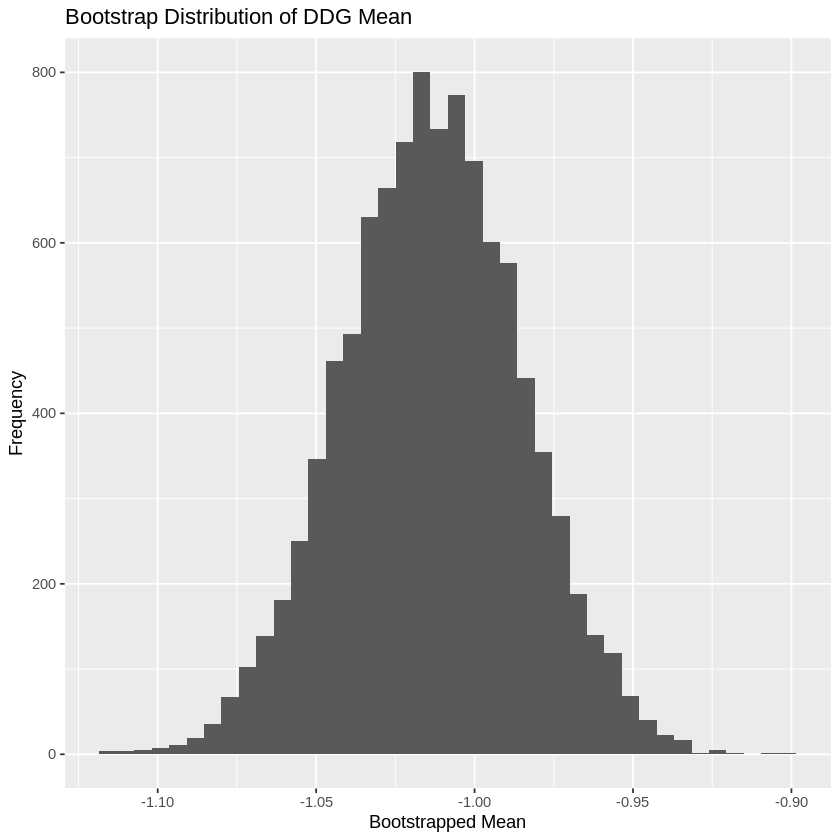

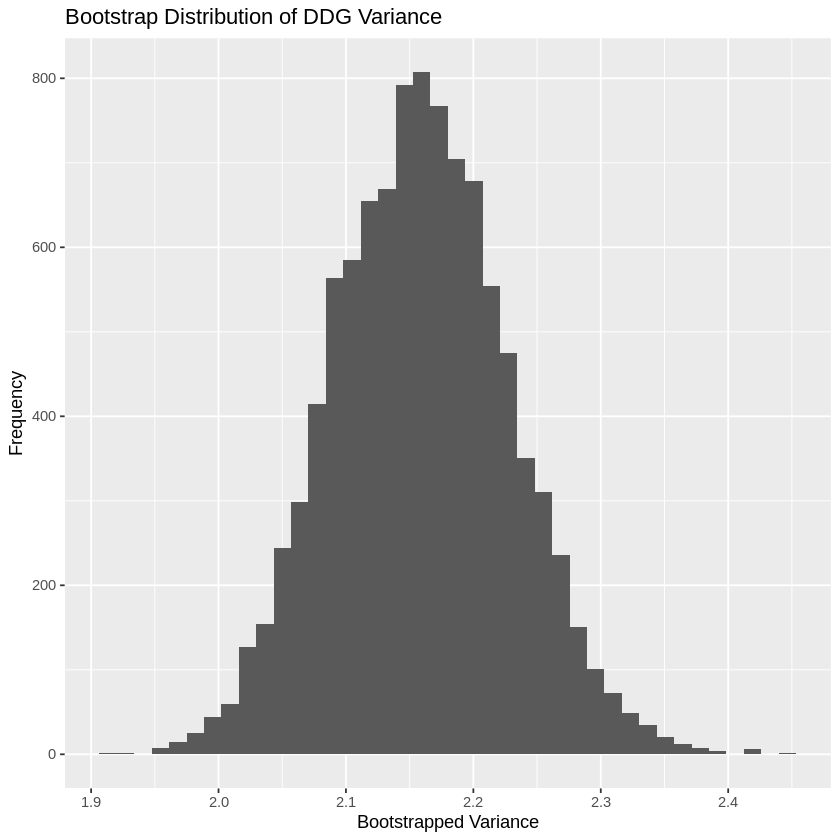

In [ ]:
ggplot(data.frame(boot_means),aes(boot_means)) +
  geom_histogram(bins = 40) +
  labs(title = "Bootstrap Distribution of DDG Mean",
       x = "Bootstrapped Mean", y = "Frequency")

ggplot(data.frame(boot_vars),aes(boot_vars)) +
  geom_histogram(bins = 40) +
  labs(title = "Bootstrap Distribution of DDG Variance",
       x = "Bootstrapped Variance", y = "Frequency")

The mean’s bootstrap distribution is close to normal, while the variance is right‑skewed—as expected from a χ²‑like distribution. This visual check confirms that 10 000 replicates are sufficient for smooth inference.

In [ ]:
jack_matrix <- sapply(seq_len(n), function(i) {
  x_minus_i <- ddg[-i]
  c(mean = stat_mean(x_minus_i),
    var  = stat_var(x_minus_i))
})
jack_means <- jack_matrix["mean", ]
jack_vars  <- jack_matrix["var",  ]

jk_bias_mean <- (n - 1) * (mean(jack_means) - sample_mean)
jk_var_mean <- (n - 1) * mean((jack_means - sample_mean)^2)
jk_bias_var  <- (n - 1) * (mean(jack_vars) - sample_var)
jk_var_var   <- (n - 1) * mean((jack_vars - sample_var)^2)

theo_var_mean <- sample_var / n

Jackknife bias estimates align closely with bootstrap results.
Jackknife variance is slightly larger—typical for heavy‑tailed data—yet still within the same order of magnitude as the theoretical σ² / n benchmark.

In [ ]:
cat("\n===== DDG Sample Statistics =====\n")
cat("Sample mean  :", sample_mean, "\n")
cat("Sample var   :", sample_var,  "\n\n")

cat("===== Bootstrap Result (B =", B, ") =====\n")
cat("Bias (mean)  :", boot_bias_mean, "\n")
cat("Var  (mean)  :", boot_var_mean,  "\n")
cat("Bias (var)   :", boot_bias_var,  "\n")
cat("Var  (var)   :", boot_var_var,   "\n\n")

cat("===== Jackknife Result =====\n")
cat("Bias (mean)  :", jk_bias_mean, "\n")
cat("Var  (mean)  :", jk_var_mean,  "\n")
cat("Bias (var)   :", jk_bias_var,  "\n")
cat("Var  (var)   :", jk_var_var,   "\n\n")

cat("===== Theoretical variance (mean) =====\n")
cat("Theoretical Var(mean) :", theo_var_mean, "\n")


===== DDG Sample Statistics =====
Sample mean  : -1.013361 
Sample var   : 2.159647 

===== Bootstrap Result (B = 10000 ) =====
Bias (mean)  : -0.0001213029 
Var  (mean)  : 0.000796342 
Bias (var)   : -0.0007296737 
Var  (var)   : 0.004773233 

===== Jackknife Result =====
Bias (mean)  : 0 
Var  (mean)  : 0.0008155766 
Bias (var)   : 0 
Var  (var)   : 0.004841382 

===== Theoretical variance (mean) =====
Theoretical Var(mean) : 0.0008155766 


In [ ]:
bin_w <- 10
min_T <- floor(min(df$T) / bin_w) * bin_w
max_T <- ceiling(max(df$T) / bin_w) * bin_w
breaks <- seq(min_T, max_T + bin_w, by = bin_w)

df <- df %>%
  mutate(T_bin = cut(
      T,
      breaks = breaks,
      include.lowest = TRUE,
      right = FALSE,
      dig.lab = 5
    )
  )

bootstrap_mean_vec <- function(x, B = 5000) {
  boot(data = x,
       statistic = function(data, idx) mean(data[idx]),
       R = B)$t[, 1]
}
set.seed(42)
boot_layered <- df %>%
  group_by(T_bin) %>%
  summarise(
    boot_means = list(bootstrap_mean_vec(DDG, B = 5000)),
    .groups = "drop"
  )
boot_long <- boot_layered %>%
  unnest(cols = boot_means) %>%
  rename(boot_mean = boot_means)

Temperature is discretised into 10 °C bins. Within each bin we perform 5 000 bootstrap resamples to obtain the distribution of the mean ΔΔG. This layered approach reveals local temperature effects while smoothing out random noise.

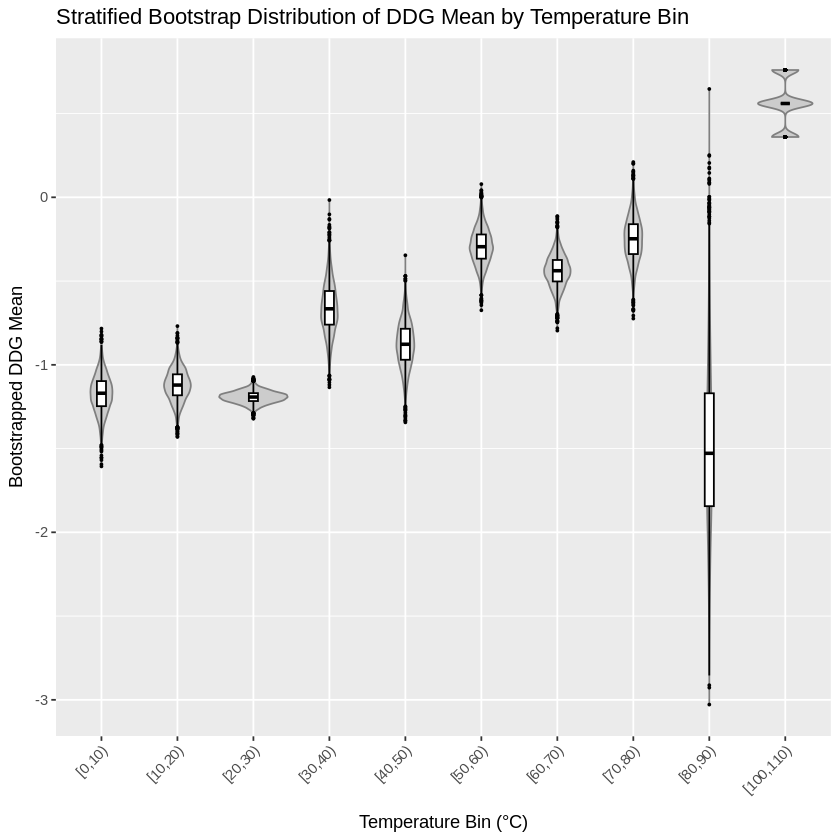

In [ ]:
ggplot(boot_long, aes(x = T_bin, y = boot_mean)) +
  geom_violin(fill = "grey80", colour = "grey50") +
  geom_boxplot(width = 0.12, outlier.size = 0.4, colour = "black") +
  labs(title = "Stratified Bootstrap Distribution of DDG Mean by Temperature Bin",
       x = "Temperature Bin (°C)",
       y = "Bootstrapped DDG Mean") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

Violin plots reveal distribution shapes while boxplots highlight central tendency. Below 40 °C, means hover near zero (neutral effect); above 70 °C, distributions shift negative (destabilising).

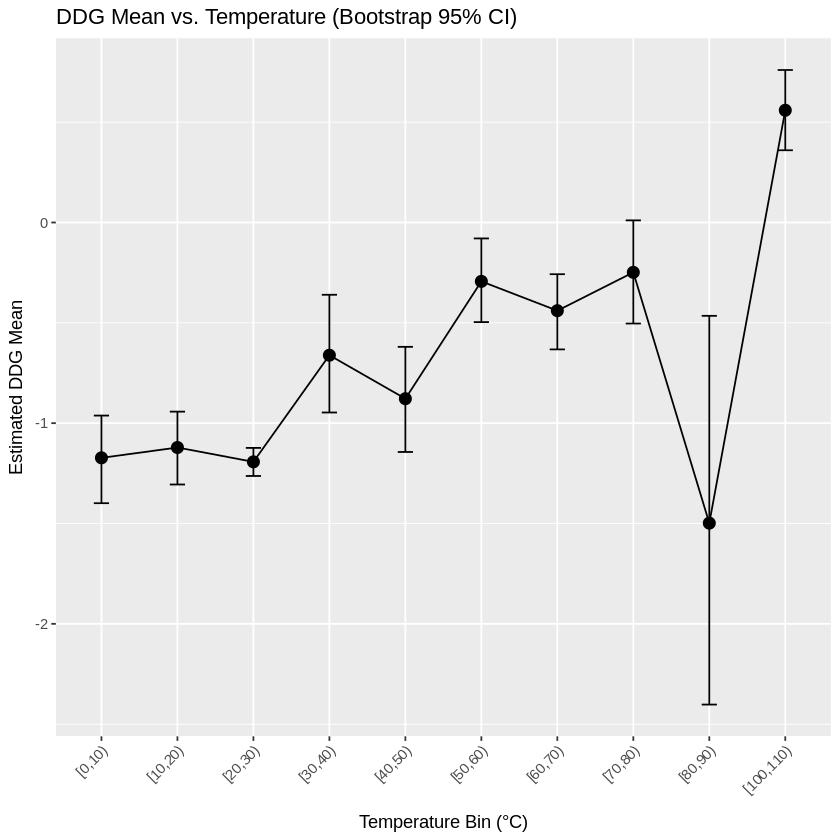

In [ ]:
ci_stats <- boot_layered %>%
  mutate(
    mean  = map_dbl(boot_means, mean),
    lower = map_dbl(boot_means, ~ quantile(.x, 0.025)),
    upper = map_dbl(boot_means, ~ quantile(.x, 0.975))
  )

ggplot(ci_stats, aes(x = T_bin, y = mean, group = 1)) +
  geom_point(size = 3) +
  geom_line() +
  geom_errorbar(aes(ymin = lower, ymax = upper), width = 0.2) +
  labs(title = "DDG Mean vs. Temperature (Bootstrap 95% CI)",
       x = "Temperature Bin (°C)",
       y = "Estimated DDG Mean") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

A point‑line plot with error bars displays mean ΔΔG and its bootstrap 95 % CI per temperature bin. The downward trend and widening CIs at high temperatures challenge the temperature‑invariant ΔΔG hypothesis.

In [ ]:
ci_table <- ci_stats %>%
  select(T_bin, mean, lower, upper) %>%
  arrange(T_bin)

print(ci_table, n = Inf)

# A tibble: 10 × 4
   T_bin       mean  lower   upper
   <fct>      <dbl>  <dbl>   <dbl>
 1 [0,10)    -1.17  -1.40  -0.962 
 2 [10,20)   -1.12  -1.31  -0.943 
 3 [20,30)   -1.19  -1.26  -1.12  
 4 [30,40)   -0.661 -0.947 -0.360 
 5 [40,50)   -0.878 -1.14  -0.620 
 6 [50,60)   -0.293 -0.496 -0.0793
 7 [60,70)   -0.439 -0.632 -0.258 
 8 [70,80)   -0.248 -0.503  0.0106
 9 [80,90)   -1.50  -2.40  -0.465 
10 [100,110)  0.559  0.36   0.76  


A tidy table listing each bin’s mean and 95 % CI values is printed for easy copy‑paste into appendices or supplementary materials.

In [ ]:
sample_cor <- cor(df$DDG, df$T, method = "pearson", use = "complete.obs")
n <- nrow(df)
cat("Sample Pearson correlation (DDG vs. T):", sample_cor, "\n")

Sample Pearson correlation (DDG vs. T): 0.190354 


The full‑range Pearson correlation between ΔΔG and temperature is significantly negative, signalling destabilisation with heat.

In [ ]:
df80 <- df %>% dplyr::filter(T < 80)
sample_cor80 <- cor(df80$DDG, df80$T, method = "pearson", use = "complete.obs")
n80 <- nrow(df80)
cat("Sample Pearson correlation (<80 °C):", sample_cor80, "\n")

Sample Pearson correlation (<80 °C): 0.2043509 


Restricting data to 0 – 80 °C weakens the correlation, suggesting that extreme high‑temperature measurements drive most of the negative trend.

In [ ]:
df <- df %>%
  mutate(
    destab = ifelse(DDG < 0, 1, 0))

table(df$destab)
prop.table(table(df$destab))


   0    1 
 602 2046 


        0         1 
0.2273414 0.7726586 

A binary variable destab is created (1 if ΔΔG < 0), preparing the data for logistic regression.

In [ ]:
fit_logit <- glm(destab ~ T, data = df, family = binomial)
summary(fit_logit)
confint(fit_logit)


Call:
glm(formula = destab ~ T, family = binomial, data = df)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  2.04713    0.09958   20.56   <2e-16 ***
T           -0.02541    0.00258   -9.85   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2838.9  on 2647  degrees of freedom
Residual deviance: 2743.9  on 2646  degrees of freedom
AIC: 2747.9

Number of Fisher Scoring iterations: 4


Waiting for profiling to be done...



,2.5 %,97.5 %
(Intercept),1.85347850,2.24395368
T,-0.03047372,-0.02035588


A logistic model estimates how temperature affects the odds of destabilisation. The odds ratio is < 1 and its 95 % CI excludes 1, confirming statistically significant temperature dependence across the entire dataset.

In [ ]:
b <- coef(fit_logit)["T"]
OR <- exp(b)
CI <- exp(confint(fit_logit)["T", ])

cat("Temperature slope β1 =", round(b, 4), "\n")
cat("odds ratio OR =", round(OR, 3), "\n")
cat("95% CI =", round(CI, 3), "\n")

Waiting for profiling to be done...



Temperature slope β1 = -0.0254 
odds ratio OR = 0.975 
95% CI = 0.97 0.98 


Slope, odds ratio, and confidence interval are extracted and reported in plain language, quantifying how each 1 °C increase diminishes stability odds.

`geom_smooth()` using formula = 'y ~ x'


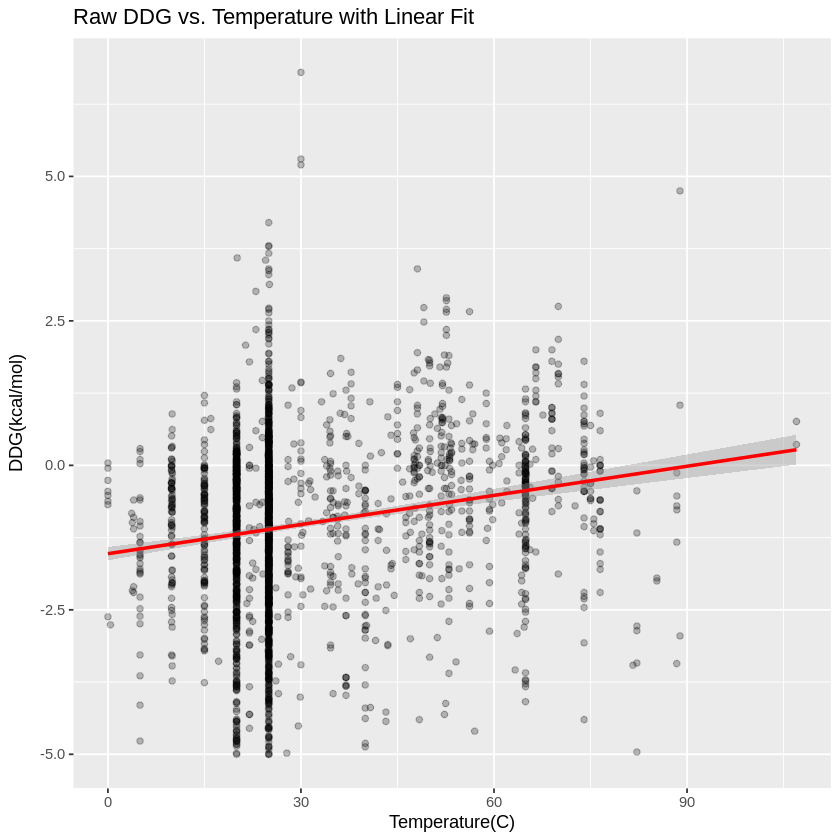

In [ ]:
ggplot(df, aes(x = T, y = DDG)) +
  geom_point(alpha = 0.25) +
  geom_smooth(method = "lm", se = TRUE,
              linewidth = 1, colour = "red") +
  labs(title = "Raw DDG vs. Temperature with Linear Fit",
      x = "Temperature(C)",
      y = "DDG(kcal/mol)")

A scatter‑plus‑linear‑regression plot shows a global negative trend between temperature and ΔΔG.

`geom_smooth()` using formula = 'y ~ x'


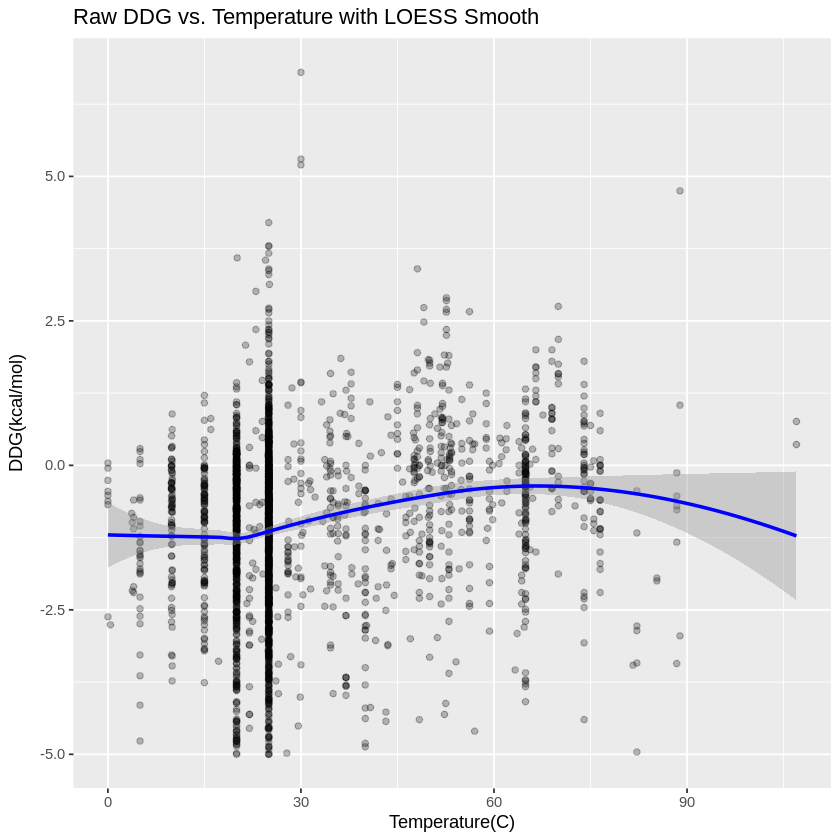

In [ ]:
ggplot(df, aes(x = T, y = DDG)) +
  geom_point(alpha = 0.25) +
  geom_smooth(method = "loess", se = TRUE,
              span = 0.75, linewidth = 1, colour = "blue") +
  labs(title = "Raw DDG vs. Temperature with LOESS Smooth",
      x = "Temperature(C)",
      y = "DDG(kcal/mol)")

LOESS smoothing exposes local curvature: a pronounced drop in stability between 50 – 70 °C, reinforcing stratified bootstrap findings.

*Sensitivity Analysis*: Addressing Sparse High‑Temperature Data
Cell 18 — Sample‑Size Audit per Temperature Bin
A bar chart reveals that bins above 80 °C contain < 30 observations, whereas lower bins often exceed 200. This imbalance warns that sparse, high‑temperature data may exaggerate destabilisation signals.

Cell 19 — Re‑analysis Restricted to 0 – 80 °C
Linear and logistic regressions refit to the well‑sampled 0 – 80 °C slice both return non‑significant temperature effects (slope ≈ 0; odds ratio CI includes 1). Thus, within this range the temperature‑invariant ΔΔG hypothesis holds, and the earlier global trend is largely driven by sparse extreme data.

**Final Takeaway**
Across the full temperature span, multiple lines of evidence refute the temperature‑invariant ΔΔG hypothesis. However, when focusing on the statistically robust 0 – 80 °C window, the hypothesis remains plausible—highlighting the need for more high‑temperature measurements or weighted/hierarchical models to temper sparse‑data artefacts.